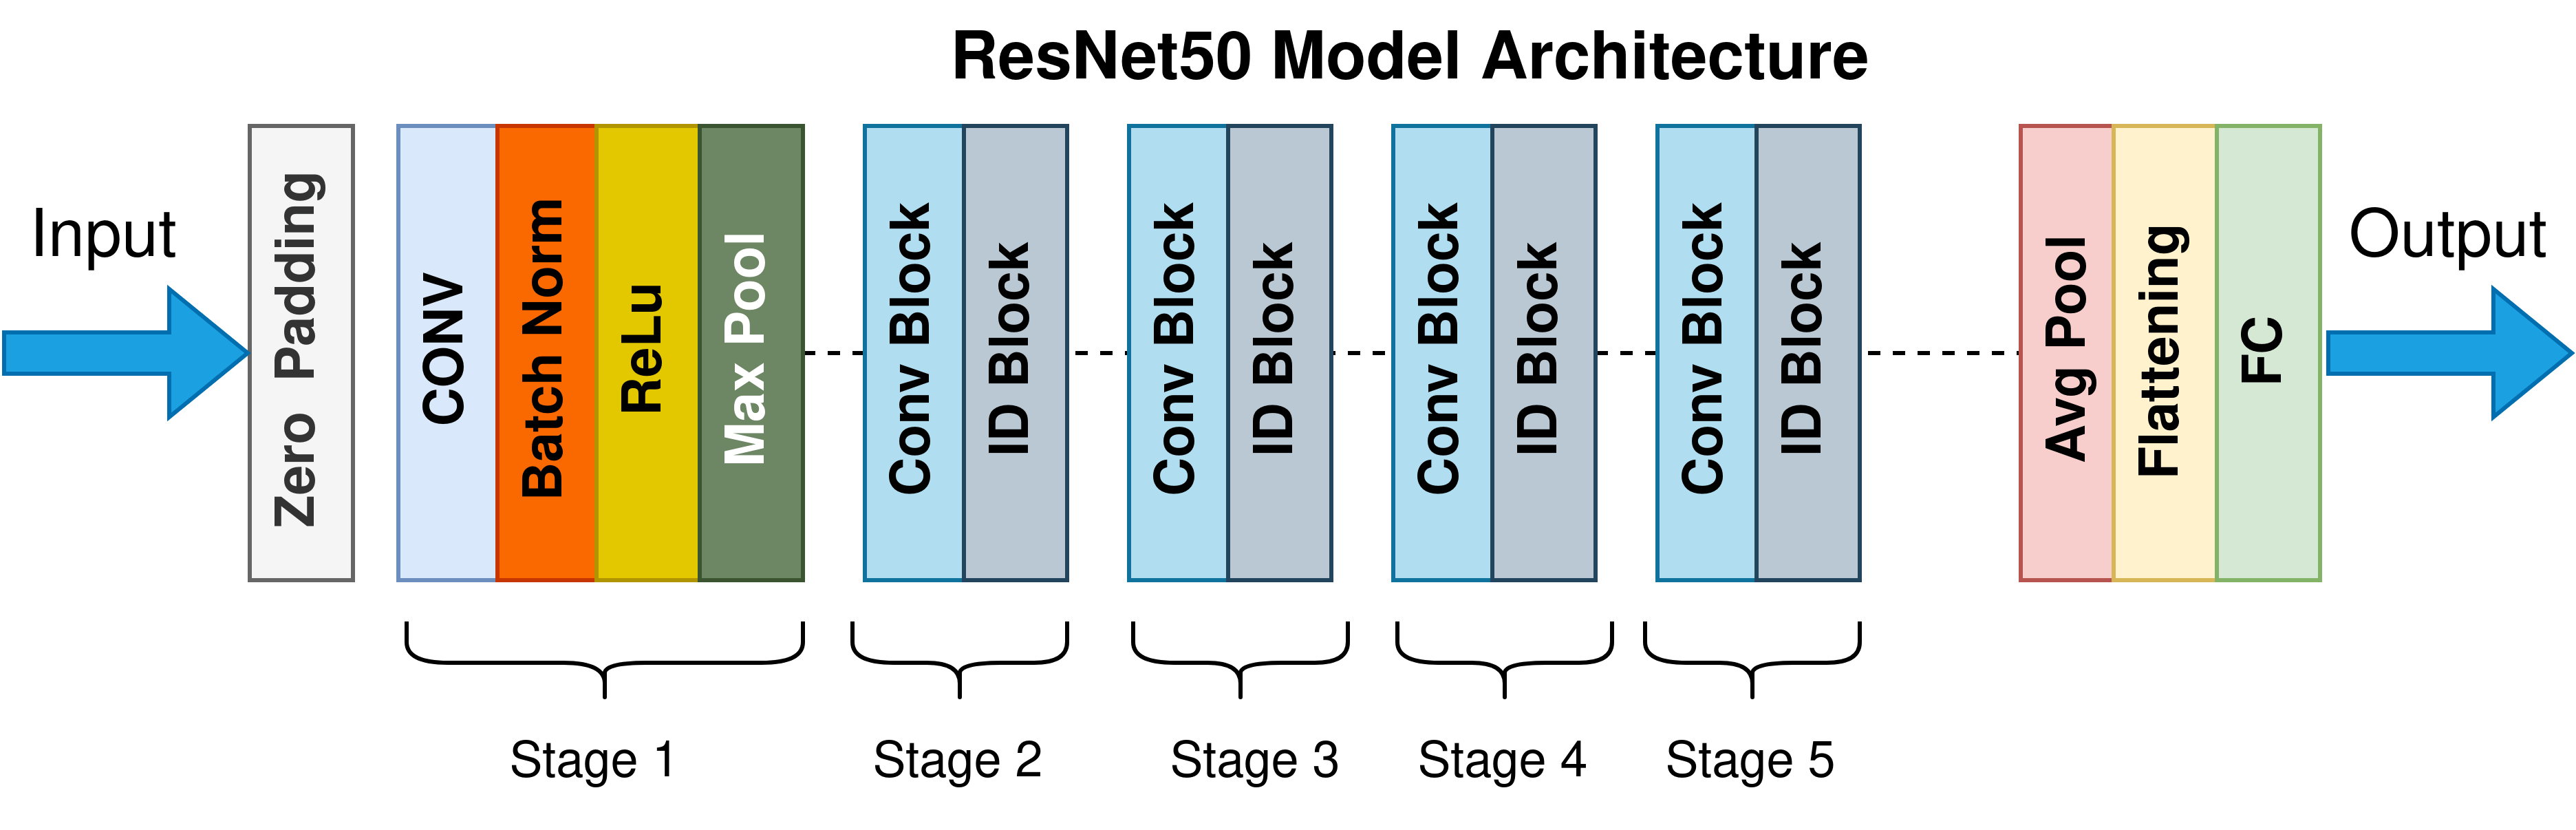

In [8]:
import tensorflow as tf

In [ ]:
class Bottleneck(tf.keras.layers.Layer):
    expansion = 4

    def __init__(self, in_channels, out_channels, input_shape, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size=1, strides=1, padding='same', 
                                            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', 
                                            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(out_channels * self.expansion, kernel_size=1, strides=1, padding='same', 
                                            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.downsample = downsample
        self.relu = tf.keras.layers.ReLU()
        if input_shape:
            self.build((None, *input_shape))

    def call(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))

        if self.downsample is not None:
            X = self.downsample(X)

        Y = Y + X
        Y = self.relu(Y)

        return Y

In [10]:
class ResNet(tf.keras.Model):
    def __init__(self, block, layers, num_classes, input_channels=3):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', 
                                            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        self.layer1 = self._make_layer(block, layers[0], planes=64)
        self.layer2 = self._make_layer(block, layers[1], planes=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], planes=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], planes=512, stride=2)

        self.GAP = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.GAP(x)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_blocks, planes, stride=1):
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes * block.expansion:
            downsample = tf.keras.Sequential([
                tf.keras.layers.Conv2D(planes * block.expansion, kernel_size=1, strides=stride, padding='same',
                                       kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
                tf.keras.layers.BatchNormalization()
            ])

        layers.append(block(self.in_channels, planes, stride, downsample))
        self.in_channels = planes * block.expansion

        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, planes))

        return tf.keras.Sequential(layers)

In [ ]:
def ResNet50(num_classes, input_shape):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, input_shape)
def ResNet101(num_classes, input_shape):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, input_shape)
def ResNet152(num_classes, input_shape):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes, input_shape)